<a href="https://colab.research.google.com/github/PRIYA-VARSHA/localrepo/blob/main/_Reading_pixel_values_CNN_GEN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import TensorDataset
from torch.optim import Adam, SGD

In [2]:
# Basic Numeric Computation
import numpy as np
import pandas as pd

In [3]:
# Look at data
from matplotlib import pyplot

In [4]:
 #Easy way to split train data
from sklearn.model_selection import train_test_split

In [6]:
# # Looking at directory
# import os
# base_dir = "../input"
# print(os.listdir(base_dir))

device = torch.device("cpu")# if torch.cuda.is_available() else torch.device("cpu")
device
epochs=12

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:

"""## 2. transform Dataset"""

# Convert Dataframe into format ready for training
def createImageData(raw: pd.DataFrame):
    y = raw['label'].values
    y.resize(y.shape[0],1)
    x = raw[[i for i in raw.columns if i != 'label']].values
    x = x.reshape([-1,1, 28, 28])
    y = y.astype(int).reshape(-1)
    x = x.astype(float)
    return x, y


In [9]:
## Convert to One Hot Encoding
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes)
    return y[labels]

x_train, y_train = createImageData(train)

In [10]:
#x_train.shape, y_train.shape, x_val.shape, y_val.shape
x_train.shape, y_train.shape

((42000, 1, 28, 28), (42000,))

In [11]:
# Normalization
mean = x_train.mean()
std = x_train.std()
x_train = (x_train-mean)/std
#x_val = (x_val-mean)/std

In [12]:
# Numpy to Torch Tensor
x_train = torch.from_numpy(np.float32(x_train)).to(device)
y_train = torch.from_numpy(y_train.astype(np.int64)).to(device)
y_train = one_hot_embedding(y_train)
#x_val = torch.from_numpy(np.float32(x_val))
#y_val = torch.from_numpy(y_val.astype(np.long))

In [13]:
"""# 3. Loading Dataset"""

# Convert into Torch Dataset
train_ds = TensorDataset(x_train, y_train)
#val_ds = TensorDataset(x_val,y_val)

In [14]:
# Make Data Loader
train_dl = DataLoader(train_ds, batch_size=64)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


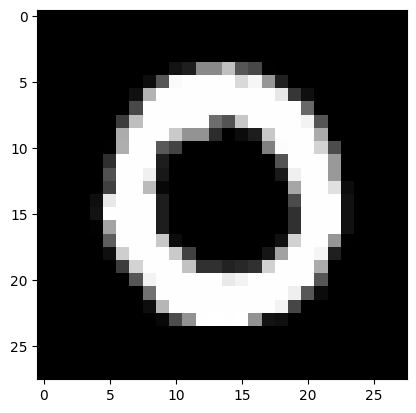

In [15]:
"""## 4. EDA"""

index = 1
pyplot.imshow(x_train.cpu()[index].reshape((28, 28)), cmap="gray")
print(y_train[index])

In [16]:
"""## 5. Model"""

# Helper Functions

## Initialize weight with xavier_uniform
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [17]:
## Flatten Later
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [18]:
# Train the network and print accuracy and loss overtime
def fit(train_dl, model, loss, optim, epochs=10):
    model = model.to(device)
    print('Epoch\tAccuracy\tLoss')
    accuracy_overtime = []
    loss_overtime = []
    for epoch in range(epochs):
        avg_loss = 0
        correct = 0
        total=0
        for x, y in train_dl: # Iterate over Data Loder

            # Forward pass
            yhat = model(x)
            l = loss(y, yhat)

            #Metrics
            avg_loss+=l.item()

            # Backward pass
            optim.zero_grad()
            l.backward()
            optim.step()

            # Metrics
            _, original =  torch.max(y, 1)
            _, predicted = torch.max(yhat.data, 1)
            total += y.size(0)
            correct = correct + (original == predicted).sum().item()

        accuracy_overtime.append(correct/total)
        loss_overtime.append(avg_loss/len(train_dl))
        print(epoch,accuracy_overtime[-1], loss_overtime[-1], sep='\t')
    return accuracy_overtime, loss_overtime

In [19]:
# Plot Accuracy and Loss of Model
def plot_accuracy_loss(accuracy, loss):
    f = pyplot.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.title.set_text("Accuracy over epochs")
    ax2.title.set_text("Loss over epochs")
    ax1.plot(accuracy)
    ax2.plot(loss, 'r:')

In [23]:
# Take an array and show what model predicts
def predict_for_index(array, model, index):
    testing = array[index].view(1,28,28)
    pyplot.imshow(x_train[index].reshape((28, 28)), cmap="gray")
    print(x_train[index].shape)
    a = model(testing.float())
    print('Prediction',torch.argmax(a,1))

In [24]:
# Define the model

ff_model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(1),
).to(device)

<ipython-input-16-ad9932724ab6>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch	Accuracy	Loss
0	0.9078571428571428	0.013513071102811707
1	0.9564523809523809	0.006790806300124994
2	0.9681666666666666	0.005031430169333466
3	0.9744761904761905	0.004080470338699183
4	0.9789047619047619	0.0034365762177187603
5	0.9826190476190476	0.0028689245630525257
6	0.9847619047619047	0.0025658396177717217
7	0.9866428571428572	0.0022901864977799644
8	0.9877857142857143	0.002063111600279128
9	0.9882857142857143	0.0019494395306694054
10	0.988904761904762	0.0018194488000095185
11	0.9901190476190476	0.001674873446262531
torch.Size([1, 28, 28])
Prediction tensor([0])


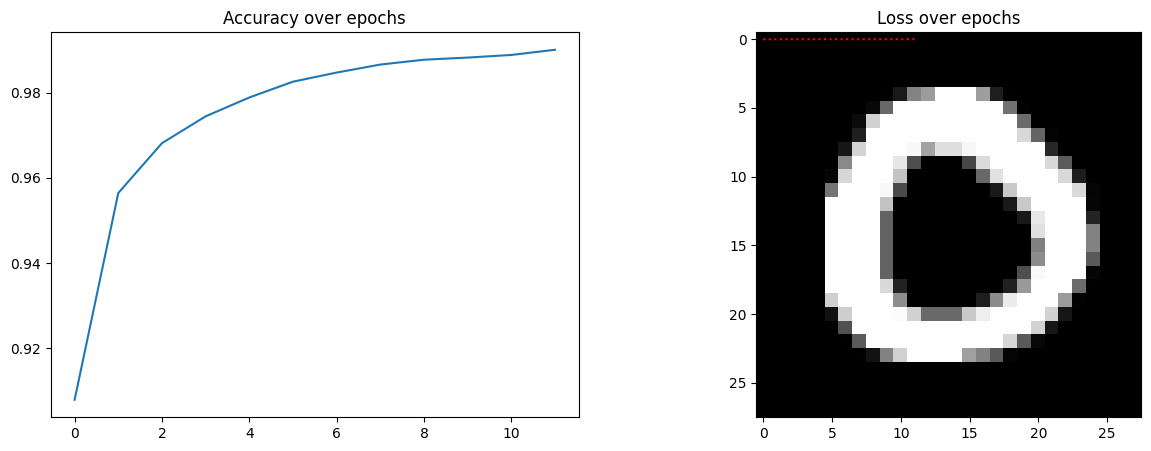

In [25]:
# Initialize model with xavier initialization which is recommended for ReLu
ff_model.apply(init_weights)

optim = Adam(ff_model.parameters())
loss = nn.MSELoss()
output = fit(train_dl, ff_model, loss, optim, epochs)
plot_accuracy_loss(*output)

index = 4
predict_for_index(x_train, ff_model, index)

<ipython-input-16-ad9932724ab6>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch	Accuracy	Loss
0	0.910047619047619	0.01649382413199095
1	0.9711428571428572	0.006798371718700301
2	0.9794285714285714	0.005163983338231808
3	0.9833095238095239	0.004314601249656891
4	0.9856428571428572	0.0037775198224495356
5	0.9874047619047619	0.003397392153777494
6	0.9886190476190476	0.003094971688503975
7	0.9893095238095239	0.002843102859253421
8	0.9902857142857143	0.0026273137582019483
9	0.9913333333333333	0.002448552973716218
10	0.9920714285714286	0.0022924269053941843
11	0.992547619047619	0.0021557785020705276


torch.Size([28000, 28, 28])

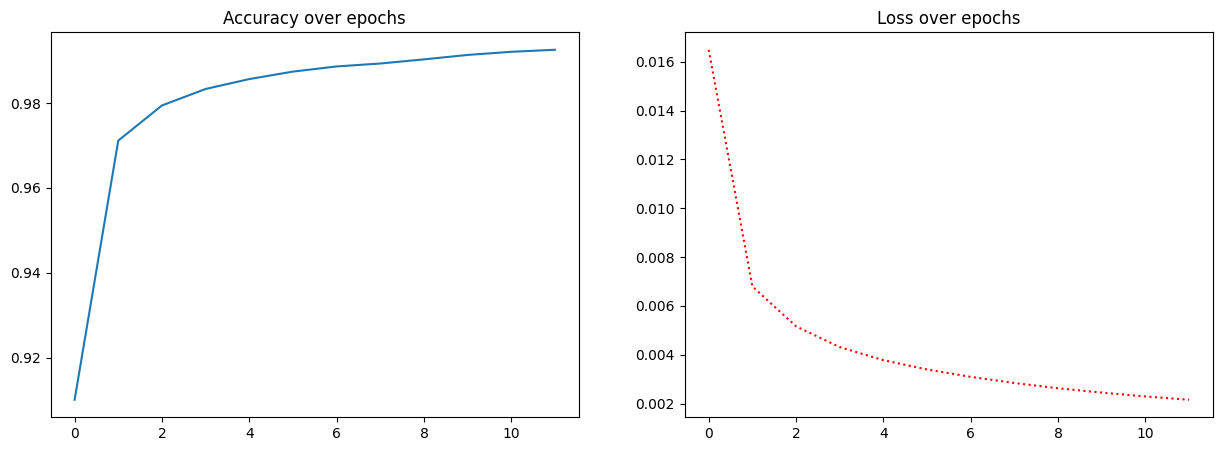

In [26]:
# A too simple NN taken from pytorch.org/tutorials
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.average1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.average2 = nn.AvgPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1)

        self.flatten = Flatten()

        self.fc1 = nn.Linear(120, 82)
        self.fc2 = nn.Linear(82,10)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.tanh(self.conv1(xb))
        xb = self.average1(xb)
        xb = F.tanh(self.conv2(xb))
        xb = self.average2(xb)
        xb = F.tanh(self.conv3(xb))
        xb = xb.view(-1, xb.shape[1])
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.fc2(xb))
        return xb

conv_model = LeNet5()
conv_model.apply(init_weights)
loss = nn.MSELoss()
optim = SGD(conv_model.parameters(), lr=0.1, momentum=0.9)
plot_accuracy_loss(*fit(train_dl, conv_model,loss,optim,epochs))

"""## Working on test data

### Normalization
"""

x_test = test.values
x_test = x_test.reshape([-1, 28, 28]).astype(float)
x_test = (torch.from_numpy(x_test) - mean) / std
x_test = torch.from_numpy(np.float32(x_test))
x_test.shape

torch.Size([1, 28, 28])
Prediction tensor([3])
torch.Size([1, 28, 28])
Prediction tensor([3])


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


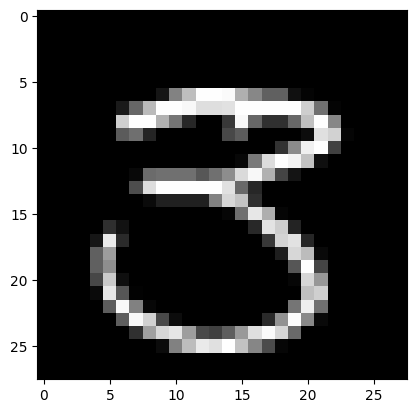

In [27]:
"""#### Prediction"""

index = 7
predict_for_index(x_test, ff_model, index)
predict_for_index(x_test, conv_model, index)

# Export data to CSV in format of submission
def export_csv(model_name, predictions, commit_no):
    df = pd.DataFrame(prediction.tolist(), columns=['Label'])
    df['ImageId'] = df.index + 1
    file_name = f'submission_{model_name}_v{commit_no}.csv'
    print('Saving ',file_name)
    df[['ImageId','Label']].to_csv(file_name, index = False)

test.head()

In [29]:
# just to make output easier to read
commit_no = 17

ff_test_yhat = ff_model(x_test.float())
prediction = torch.argmax(ff_test_yhat,1)
print('Prediction',prediction)
export_csv('ff_model',prediction, commit_no=commit_no)

cn_train_yhat = conv_model(x_test)
prediction = torch.argmax(cn_train_yhat,1)
yo = torch.argmax(y_train,1)
export_csv('lenet_model',prediction, commit_no=commit_no)

Prediction tensor([2, 0, 9,  ..., 3, 9, 2])
Saving  submission_ff_model_v17.csv
Saving  submission_lenet_model_v17.csv


In [30]:

"""### Ensembling"""

models = []
optims = []
loss = nn.MSELoss()
ensembles = 15
import sys
for i in range(ensembles):
    sys.stdout.write(f'Ensemble No {i+1}\n')
    model = LeNet5()
    model.apply(init_weights)
    #optim = Adam(model.parameters())
    optim = SGD(model.parameters(), lr=0.1, momentum=0.9)

    accuracy, _ = fit(train_dl, model,loss,optim,epochs)
    if accuracy[-1] > 95:
        models.append(model)
        optims.append(optim)

ensemble = cn_train_yhat

for model in models:
    ensemble+=model(x_test)

ensemble_one_hot = torch.argmax(ensemble,1) # Find argmax
export_csv(f'ensemble_{ensembles}_LeNets',ensemble_one_hot, commit_no=commit_no)

ensemble_one_hot

ensemble = ff_test_yhat + cn_train_yhat # Add probabilities of individual predictions
ensemble_one_hot = torch.argmax(y_train,1) # Find argmax
export_csv('ensemble',ensemble_one_hot, commit_no=commit_no)

"""### Final Accuracy achieved= 98.94%

Thanks
"""

Ensemble No 1
Epoch	Accuracy	Loss


<ipython-input-16-ad9932724ab6>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


0	0.9158809523809524	0.015961899969987627
1	0.9728095238095238	0.006649006538013708
2	0.9810952380952381	0.004953938223070024
3	0.9844047619047619	0.004108147854070481
4	0.9867857142857143	0.003561803331556822
5	0.9883095238095239	0.003170221695365296
6	0.9893809523809524	0.0028664553534420976
7	0.9902619047619048	0.0026303553164198066
8	0.990904761904762	0.0024311296987174365
9	0.991452380952381	0.002264992453641991
10	0.9922380952380953	0.0021237636054476194
11	0.9926904761904762	0.0020002965038642996
Ensemble No 2
Epoch	Accuracy	Loss
0	0.7773095238095238	0.029383897676474247
1	0.8757142857142857	0.01662094688363362
2	0.8839047619047619	0.014792155528290812
3	0.888452380952381	0.013858269432650332
4	0.8908809523809523	0.01325807463635706
5	0.8926428571428572	0.01282372663847966
6	0.8937142857142857	0.012506117012643763
7	0.8948095238095238	0.0122573454431974
8	0.8953571428571429	0.012055577321865425
9	0.8959761904761905	0.011883275223863303
10	0.8965238095238095	0.011737847762023591


'### Final Accuracy achieved= 98.94%\n\nThanks\n'